In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
alt.data_transformers.disable_max_rows()
alt.display.renderers.enable('svg')
import matplotlib.pyplot as plt

import act
import act.discovery, act.io

import metpy.calc, metpy.constants
from metpy.units import units
import glob
from tqdm import tqdm
from sublimpy import utils
import datetime as dt
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
def w_h2o_to_watts(values):
    latent_heat_of_vaporization = 2838 * units("J/g")
    latent_heat_flux_meas_units = values * units("g/(m^2 * s)")
    

In [2]:
startdate = "2022-11-30"
enddate = "2023-05-10"

In [3]:
data_dir = "/Users/elischwat/Development/data/sublimationofsnow/"
# for SAIL data queries
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'

In [4]:
sos_fn = '../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet'
sos_df = pd.read_parquet(sos_fn)

In [5]:
sos_df_localtime = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

# Examine synoptic winds, with doppler lidar (PPI/VAD)

### Open files

In [6]:
SAIL_DATA_STREAM = 'gucdlprofwind4newsM1.c1'
DATA_STREAM_FILEEXT = '.nc'
output_dir = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SAIL_DATA_STREAM)

In [7]:
# act.discovery.download_arm_data(username, token, SAIL_DATA_STREAM, startdate, enddate, output=output_dir)

In [8]:
dl_w_prof_files = glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwind4newsM1.c1/*.nc")

In [9]:
prof_ds = act.io.read_arm_netcdf(dl_w_prof_files[0:1000])
prof_ds.time.min(), prof_ds.time.max()
prof_ds = prof_ds.sel(time = slice(startdate, enddate))

In [10]:
prof_ds.time.min(), prof_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T00:00:39.646250000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-05-10T23:59:21.054324000', dtype='datetime64[ns]'))

In [11]:
prof_df = prof_ds.to_dataframe()
prof_df_localtime = utils.modify_df_timezone(prof_df.reset_index(), 'UTC', 'US/Mountain').set_index('time')

# Calculate mean synoptic winds, gap fill, calculate statistics for how much good data there is

## Use DL PPI Profile data

In [12]:
synoptic_winds_15min = prof_df_localtime.query("height >= 1000").query("height <= 1500")[
    ['wind_speed', 'u', 'v']
].reset_index().groupby('time').apply(lambda g: g.mean(skipna=True))

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_4618/2944376895.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ].reset_index().groupby('time').apply(lambda g: g.mean(skipna=True))


In [13]:
synoptic_winds_15min_filled = synoptic_winds_15min.ffill(limit=12).bfill(limit=1)
synoptic_winds_30min = synoptic_winds_15min_filled.groupby(
    pd.Grouper(freq='30min')
).apply(lambda g: g.mean(skipna=True))

In [14]:
synoptic_winds_30min['wind_direction'] = np.rad2deg(np.arctan2(
    - synoptic_winds_30min['u'],
    - synoptic_winds_30min['v'],
))
synoptic_winds_30min['wind_direction'] = synoptic_winds_30min['wind_direction'].apply(
    lambda d: d+360 if d < 0 else d
)

In [15]:
len(synoptic_winds_30min), len(synoptic_winds_30min.dropna())

(7778, 5168)

## Use Rawinsonde data to fill gaps, using rawinsondes to apply for +/- 3 hours on either side of the release time

### Download/open data

In [16]:
sonde_data_code = 'gucsondewnpnM1.b1'

In [17]:
# # # Download the data
# files = act.discovery.download_arm_data(
#     username,
#     token,
#     sonde_data_code,
#     startdate,
#     startdate,
#     output = os.path.join(data_dir, sonde_data_code)
# )
# files = sorted(files)

In [18]:
files = sorted(glob.glob(os.path.join(data_dir, sonde_data_code, f"*.cdf")))

In [19]:
sondes_ds = xr.open_mfdataset(files)
sondes_ds = sondes_ds.sel(time = slice(startdate, enddate))
sondes_df = sondes_ds.to_dataframe().reset_index()
sondes_df = utils.modify_df_timezone(sondes_df, 'UTC', 'US/Mountain')
sondes_df['date'] = sondes_df.time.dt.date.astype(str)
sondes_df['hour'] = sondes_df.time.dt.hour
sondes_df['timeofday'] = (sondes_df['hour'] < 12).apply(lambda is_morning: 'Morning' if is_morning else 'Afternoon')
sondes_df['height'] = sondes_df['alt'] - 2891

In [20]:
sondes_ds.time.min(), sondes_ds.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-30T11:29:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-05-10T23:59:59.000000000', dtype='datetime64[ns]'))

In [21]:
sondes_df_fulldataset = sondes_df.query("height <= 4000")

In [22]:
sondes_df = sondes_df.query("height >= 1000").query("height <= 1500").groupby(['date', 'timeofday']).mean()[['wspd', 'u_wind', 'v_wind']].rename(
    columns={'wspd': 'wind_speed'}
)

In [23]:
sondes_df['wind_direction'] = np.rad2deg(np.arctan2(
    - sondes_df['u_wind'],
    - sondes_df['v_wind'],
))

sondes_df['wind_direction'] = sondes_df['wind_direction'].apply(
    lambda d: d+360 if d < 0 else d
)

In [24]:
import datetime as dt

In [25]:
sondes_df['datetime'] =  pd.to_datetime(sondes_df.reset_index().apply(
    lambda row: dt.datetime(
        pd.to_datetime(row['date']).year,
        pd.to_datetime(row['date']).month,
        pd.to_datetime(row['date']).day,
        hour=4,
        minute=30
    ) if row['timeofday'] == 'Morning'
    else
    dt.datetime(
        pd.to_datetime(row['date']).year,
        pd.to_datetime(row['date']).month,
        pd.to_datetime(row['date']).day,
        hour=16,
        minute=30
    ),
    axis=1
)).values

### create new rows so the rawinsonde measurement is there for +/- 3 hours around the time of release

In [26]:
cols = ['wind_speed',	'wind_direction', 'datetime']
sondes_df = pd.concat([
    sondes_df.reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=30)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=60)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=90)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=120)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=150)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] + dt.timedelta(minutes=180)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=30)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=60)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=90)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=120)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=150)).reset_index()[cols],
    sondes_df.assign(datetime = sondes_df['datetime'] - dt.timedelta(minutes=180)).reset_index()[cols],
]).set_index('datetime').sort_index()

### fill gaps

In [27]:
synoptic_winds_30min_filledwithradiosondes = synoptic_winds_30min.copy()
synoptic_winds_30min_filledwithradiosondes['wind_speed'] = synoptic_winds_30min_filledwithradiosondes['wind_speed'].fillna(
    sondes_df['wind_speed']
)
synoptic_winds_30min_filledwithradiosondes['wind_direction'] = synoptic_winds_30min_filledwithradiosondes['wind_direction'].fillna(
    sondes_df['wind_direction']
)
synoptic_winds_30min = synoptic_winds_30min_filledwithradiosondes[['wind_speed', 'wind_direction']]

In [28]:
len(synoptic_winds_30min), len(synoptic_winds_30min.dropna())

(7778, 6576)

# Plot wind rose with wind-direction categories

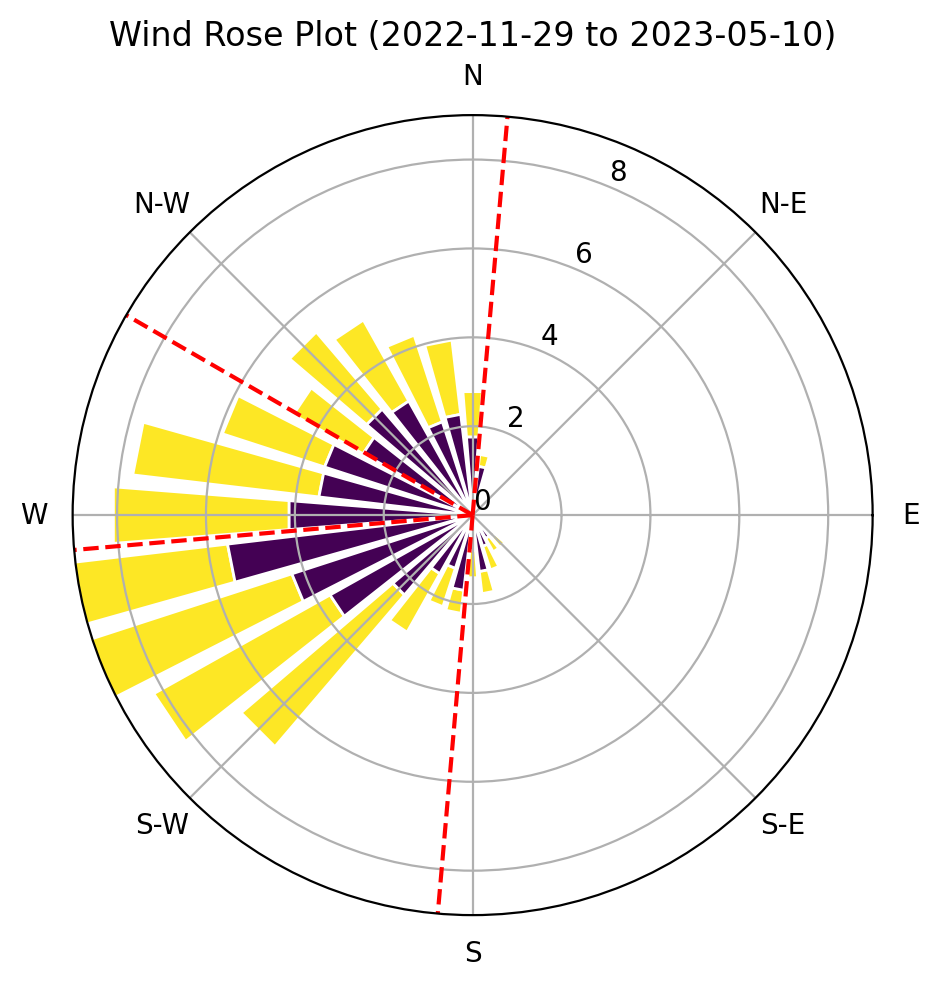

In [29]:
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import numpy as np
# Create a wind rose plot
fig = plt.figure(figsize=(5,5), dpi=200) 
ax = WindroseAxes.from_ax(fig=fig)
wind_rose_src = synoptic_winds_30min_filledwithradiosondes.dropna()
ax.bar(
    wind_rose_src['wind_direction'], 
    wind_rose_src['wind_speed'], 
    edgecolor='white',
    opening=0.8, 
    normed=True,
    nsector=32,
    bins = np.arange(0, 20, 10)
)

# Add a line at theta = 299 degrees
# theta = np.deg2rad(-299 + 90)  # Convert degrees to radians
# ax.plot([np.deg2rad(-202 + 90), np.deg2rad(-202 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-248 + 90), np.deg2rad(-248 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-299 + 90), np.deg2rad(-299 + 90)], [0, 19], color='red', linestyle='--')
# ax.plot([np.deg2rad(-345 + 90), np.deg2rad(-345 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-185 + 90), np.deg2rad(-185 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-265 + 90), np.deg2rad(-265 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-300 + 90), np.deg2rad(-300 + 90)], [0, 19], color='red', linestyle='--')
ax.plot([np.deg2rad(-5 + 90), np.deg2rad(-5 + 90)], [0, 19], color='red', linestyle='--')

# Customize the plot
ax.set_title(f"Wind Rose Plot ({wind_rose_src.index.min().date()} to {wind_rose_src.index.max().date()})")
# ax.set_legend(title="Frequency (%)", loc='lower right')
ax.set_ylim(0,9)
ax.set_yticks(np.arange(0, 10, step=2))
ax.set_yticklabels(np.arange(0, 10, step=2))
# ax.set_xlim(0.5*np.pi,1.5*np.pi)
plt.show()

# Create synoptic wind speed/direction categories and save to files 

Speed categories

In [30]:
winds_ge10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 10 ] 
winds_le10_times = synoptic_winds_30min [ synoptic_winds_30min.wind_speed <= 10 ] 

Direction categories

In [31]:
# along_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 299)
#     & (synoptic_winds_30min.wind_direction < 345 )
# ].index.values
# cross_valley_wind_times = synoptic_winds_30min[
#     (synoptic_winds_30min.wind_direction > 202)
#     & (synoptic_winds_30min.wind_direction < 270 )
# ].index.values
# len(cross_valley_wind_times), len(along_valley_wind_times)


# Better option??
# 185-265, 
# 300 - 5

along_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 300)
    | (synoptic_winds_30min.wind_direction < 5 )
].index.values
cross_valley_wind_times = synoptic_winds_30min[
    (synoptic_winds_30min.wind_direction > 185)
    & (synoptic_winds_30min.wind_direction < 265 )
].index.values
print(len(synoptic_winds_30min), len(cross_valley_wind_times), len(along_valley_wind_times))
print("PERCENT OF DATA THAT FALLS INTO EITHER CATEGORY:")
print('\t',
    100 *  round((len(cross_valley_wind_times) + len(along_valley_wind_times)) / len(synoptic_winds_30min), 4)
)


7778 2917 1614
PERCENT OF DATA THAT FALLS INTO EITHER CATEGORY:
	 58.25


In [32]:
N_fast_cross_winds = len(set(winds_ge10_times.index).intersection(pd.to_datetime(cross_valley_wind_times)))
N_fast_along_winds = len(set(winds_ge10_times.index).intersection(pd.to_datetime(along_valley_wind_times)))
N_slow_cross_winds = len(set(winds_le10_times.index).intersection(pd.to_datetime(cross_valley_wind_times)))
N_slow_along_winds = len(set(winds_le10_times.index).intersection(pd.to_datetime(along_valley_wind_times)))

print(f"fast, cross valley winds, N = {N_fast_cross_winds}")
print(f"fast, along valley winds, N = {N_fast_along_winds}")
print(f"slow, cross valley winds, N = {N_slow_cross_winds}")
print(f"slow, along valley winds, N = {N_slow_along_winds}")

print(f"Percent of cross-valley winds that are fast, {round(100*N_fast_cross_winds / (N_fast_cross_winds + N_slow_cross_winds), 1)}")
print(f"Percent of along-valley winds that are fast, {round(100*N_fast_along_winds / (N_fast_along_winds + N_slow_along_winds), 1)}")

fast, cross valley winds, N = 1625
fast, along valley winds, N = 732
slow, cross valley winds, N = 1292
slow, along valley winds, N = 882
Percent of cross-valley winds that are fast, 55.7
Percent of along-valley winds that are fast, 45.4


In [33]:
cross_valley_wind_times = pd.Series(cross_valley_wind_times)
along_valley_wind_times = pd.Series(along_valley_wind_times)

In [34]:
cross_valley_wind_times.to_csv('cross_valley_wind_times.csv')
along_valley_wind_times.to_csv('along_valley_wind_times.csv')
pd.Series(winds_ge10_times.index).to_csv('winds_ge10_times.csv')
pd.Series(winds_le10_times.index).to_csv('winds_le10_times.csv')

# Create stability categories for further breaking down the data

static stability, bulk, 0-3m

In [35]:
bulk_static_stability = sos_df_localtime.query("variable == 'Tsurfpot_c'").set_index('time')[['value']].join(
    sos_df_localtime.query("variable == 'Tpot_3m_c'").set_index('time')['value'].rename('3m')
)
bulk_static_stability['d_theta_d_z'] = (
    (bulk_static_stability['3m'] - bulk_static_stability['value']) / 3
)
bulk_static_stability.head()

,value,3m,d_theta_d_z
time,,,
2022-10-31 18:00:00,21.450195,27.961304,2.170369
2022-10-31 18:30:00,20.658997,26.929535,2.090179
2022-10-31 19:00:00,20.236237,26.272247,2.012004
2022-10-31 19:30:00,19.949768,26.159027,2.069753
2022-10-31 20:00:00,19.014709,25.450684,2.145325


In [36]:
tgrad_stable_times = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z > 0.05").index))
tgrad_unstable_times = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z < -0.05").index))
tgrad_neutral_times = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z >= -0.05").query("d_theta_d_z <= 0.05").index))

print(len(tgrad_stable_times))  
print(len(tgrad_neutral_times)) 
print(len(tgrad_unstable_times))    

9143
260
1277


static stability, bulk, 3-20m

In [37]:
bulk_static_stability = sos_df_localtime.query("variable == 'Tpot_20m_c'").set_index('time')[['value']].join(
    sos_df_localtime.query("variable == 'Tpot_3m_c'").set_index('time')['value'].rename('3m')
)
bulk_static_stability['d_theta_d_z'] = (
    (bulk_static_stability['value'] - bulk_static_stability['3m']) / 17
)
bulk_static_stability.head()

,value,3m,d_theta_d_z
time,,,
2022-10-31 18:00:00,29.882141,27.961304,0.112990
2022-10-31 18:30:00,28.493652,26.929535,0.092007
2022-10-31 19:00:00,28.271088,26.272247,0.117579
2022-10-31 19:30:00,27.923492,26.159027,0.103792
2022-10-31 20:00:00,27.689880,25.450684,0.131717


In [38]:
tgrad_stable_times_3to20 = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z > 0.05").index))
tgrad_unstable_times_3to20 = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z < -0.05").index))
tgrad_neutral_times_3to20 = list(pd.to_datetime(bulk_static_stability.query("d_theta_d_z >= -0.05").query("d_theta_d_z <= 0.05").index))

print(len(tgrad_stable_times_3to20))  
print(len(tgrad_neutral_times_3to20)) 
print(len(tgrad_unstable_times_3to20))    

4094
6581
366


# Examine synoptic wind statistics

In [39]:
synoptic_winds_pdf_data = pd.concat([
        synoptic_winds_30min[synoptic_winds_30min.index.isin(cross_valley_wind_times)].assign(synoptic_wind = 'cross valley'),
        synoptic_winds_30min[synoptic_winds_30min.index.isin(along_valley_wind_times)].assign(synoptic_wind = 'along valley')
    ])

<Axes: ylabel='Frequency'>

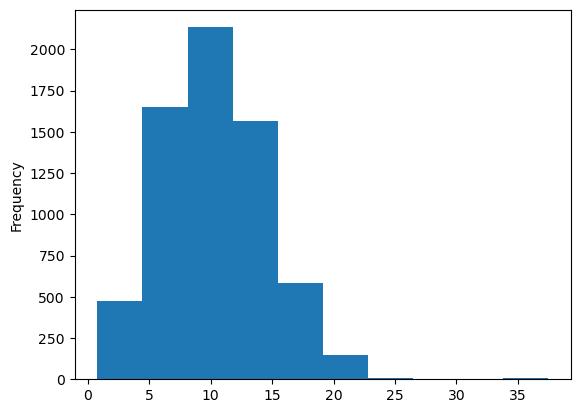

In [40]:
synoptic_winds_30min.wind_speed.plot.hist()

In [41]:
top_20_max_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].max().sort_values('wind_speed', ascending=False).head(20).index
top_20_avg_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d'))[['wind_speed']].mean().sort_values('wind_speed', ascending=False).head(20).index

In [42]:
for datetime in top_20_max_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-04
cross 26
along 0

2023-04-04
cross 22
along 6

2023-03-22
cross 37
along 0

2023-02-22
cross 29
along 0

2023-04-03
cross 42
along 0

2023-03-08
cross 33
along 0

2022-12-02
cross 25
along 1

2023-02-05
cross 34
along 0

2022-12-01
cross 37
along 0

2023-01-29
cross 45
along 0

2022-12-05
cross 41
along 0

2023-03-06
cross 35
along 0

2023-03-05
cross 46
along 1

2023-04-18
cross 45
along 0

2023-02-19
cross 16
along 2

2023-02-24
cross 35
along 0

2023-04-02
cross 32
along 0



In [43]:
for datetime in top_20_avg_windspeed_days:
    cross_cnt = len(cross_valley_wind_times[cross_valley_wind_times.dt.date == datetime.date()])
    along_cnt = len(along_valley_wind_times[along_valley_wind_times.dt.date == datetime.date()])
    if cross_cnt > along_cnt:
        print(datetime.date())
        print('cross', cross_cnt)
        print('along', along_cnt)
        print()

2023-03-04
cross 26
along 0

2023-03-06
cross 35
along 0

2022-11-30
cross 15
along 0

2023-02-28
cross 26
along 0

2023-02-05
cross 34
along 0

2023-03-28
cross 19
along 0

2023-03-08
cross 33
along 0

2023-02-24
cross 35
along 0

2023-03-22
cross 37
along 0

2023-04-03
cross 42
along 0

2023-03-10
cross 38
along 0

2023-02-22
cross 29
along 0

2022-12-02
cross 25
along 1

2022-12-12
cross 10
along 1

2022-12-11
cross 31
along 0



In [44]:
top_12_windspeed_days = synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().sort_values('wind_speed', ascending=False).head(12).index
top_12_windspeed_days[0]
for dt in top_12_windspeed_days:
    print(len(cross_valley_wind_times[cross_valley_wind_times.dt.date == dt.date]))
    print(len(along_valley_wind_times[along_valley_wind_times.dt.date == dt.date]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [45]:
synoptic_winds_pdf_data.index.min(), synoptic_winds_pdf_data.index.max()

(Timestamp('2022-11-30 13:30:00'), Timestamp('2023-05-10 17:30:00'))

In [46]:
synoptic_winds_pdf_data.groupby(pd.Grouper(freq='1d')).max().wind_speed.quantile(0.90)

19.9717960357666

In [47]:
synoptic_winds_pdf_data.synoptic_wind.value_counts()

synoptic_wind
cross valley    2917
along valley    1614
Name: count, dtype: int64

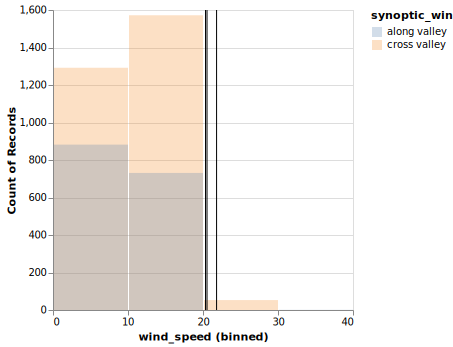

In [48]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=10),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

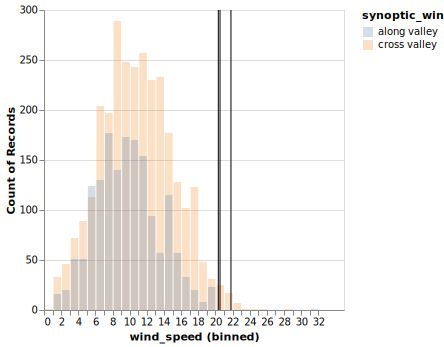

In [49]:
alt.Chart(synoptic_winds_pdf_data).mark_bar(opacity=0.25).encode(
    alt.X('wind_speed:Q').bin(step=1),
    alt.Y('count():Q', stack=False),
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

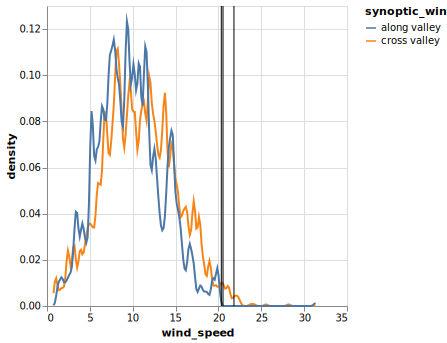

In [50]:
alt.Chart(synoptic_winds_pdf_data).transform_density(
    'wind_speed',
    as_=['wind_speed', 'density'],
    groupby = ['synoptic_wind'],
    bandwidth=0.2,
).mark_line().encode(
    x='wind_speed:Q',
    y='density:Q',
    color='synoptic_wind:N'
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230306'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230308'].wind_speed.max())
) + alt.Chart().mark_rule().encode(
    x=alt.datum(synoptic_winds_pdf_data.loc['20230418'].wind_speed.max())
)

# Examine vertical profiles of vertical velocity statistics, with doppler lidar (vertical staring)

In [51]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)

Download between start and end date

In [52]:
# file_list = act.discovery.download_arm_data(
#     username, token, DLW_DATA_STREAM, '20230409', '20230409', output = DLW_OUTPUT_DIR
# )

Or just open existing files between start and end date

In [53]:
files = glob.glob(os.path.join(DLW_OUTPUT_DIR, "*.nc"))
# Function to extract date from filename (adjust regex or slicing as needed)
def extract_date(filename):
    # Assuming filenames have a format like "data_YYYYMMDD.nc"
    basename = os.path.basename(filename)
    date_str = basename.split('gucdlprofwstats4newsM1.c1.')[1].split('.000000')[0]  # Adjust based on your filename format
    return date_str

# Filter files based on date range
file_list = [
    file for file in files
    if startdate.replace('-','') <= extract_date(file) <= enddate.replace('-','')
]

In [54]:
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [55]:
dl_wstats.time.min(), dl_wstats.time.max()

(<xarray.DataArray 'time' ()> Size: 8B
 array('2022-11-29T17:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()> Size: 8B
 array('2023-05-10T17:50:00.000000000', dtype='datetime64[ns]'))

In [56]:
df_wstats = dl_wstats[['w_variance', 'w_skewness', 'snr']].to_dataframe()
df_wstats = df_wstats[df_wstats.snr > 0.008]

In [57]:
df_wstats_30min = df_wstats.reset_index().set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
df_wstats_30min


,time,height,w_variance,w_skewness,snr,time (US/Mountain),time (UTC)
0,2022-11-29 17:00:00,15.0,0.000234,-0.379480,0.030390,2022-11-29 17:10:00,2022-11-30 00:10:00
1,2022-11-29 17:00:00,45.0,1.077502,-0.319172,0.851177,2022-11-29 17:10:00,2022-11-30 00:10:00
2,2022-11-29 17:00:00,75.0,0.555193,-0.303367,1.468834,2022-11-29 17:10:00,2022-11-30 00:10:00
3,2022-11-29 17:00:00,105.0,0.693679,-0.316026,1.532165,2022-11-29 17:10:00,2022-11-30 00:10:00
4,2022-11-29 17:00:00,135.0,0.888906,-0.538809,1.555035,2022-11-29 17:10:00,2022-11-30 00:10:00
...,...,...,...,...,...,...,...
277377,2023-05-10 17:30:00,2025.0,NaN,5.206299,0.124150,2023-05-10 17:30:00,2023-05-10 23:30:00
277378,2023-05-10 17:30:00,2055.0,NaN,-0.048728,0.056236,2023-05-10 17:30:00,2023-05-10 23:30:00
277379,2023-05-10 17:30:00,2085.0,NaN,0.888623,0.031547,2023-05-10 17:30:00,2023-05-10 23:30:00
277380,2023-05-10 17:30:00,2115.0,6.665097,2.699510,0.017985,2023-05-10 17:30:00,2023-05-10 23:30:00


## Variance

In [58]:
df_wstats_along_valley = df_wstats_30min[df_wstats_30min.time.isin(along_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'along-valley')
df_wstats_cross_valley = df_wstats_30min[df_wstats_30min.time.isin(cross_valley_wind_times)].query("height < 2000").assign(synoptic_wind_direction = 'cross-valley')

df_wstats_with_synoptic_conditions = pd.concat([
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_along_valley[df_wstats_along_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_ge10_times.index)].assign(synoptic_wind_speed = '> 10'),
    df_wstats_cross_valley[df_wstats_cross_valley.time.isin(winds_le10_times.index)].assign(synoptic_wind_speed = '<= 10')
])

#### Median plot for April 18

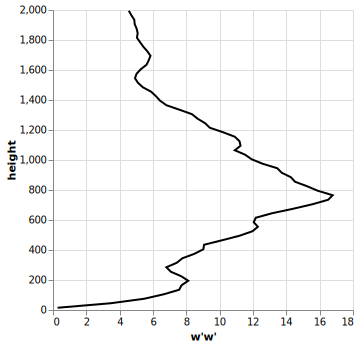

In [59]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_variance_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_variance):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_2000_2100_median_variance_profile

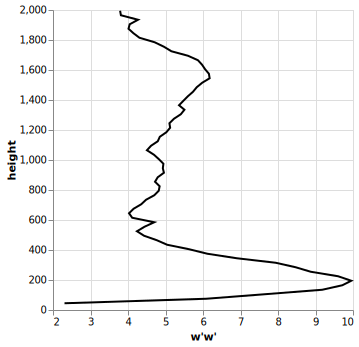

In [60]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_1400_1500_median_variance_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 1400': '20230418 1500'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_variance)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_variance):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_1400_1500_median_variance_profile

In [61]:
print('tgrad_stable_times', len(tgrad_stable_times))
print('tgrad_unstable_times', len(tgrad_unstable_times))
print('tgrad_neutral_times', len(tgrad_neutral_times))

tgrad_stable_times 9143
tgrad_unstable_times 1277
tgrad_neutral_times 260


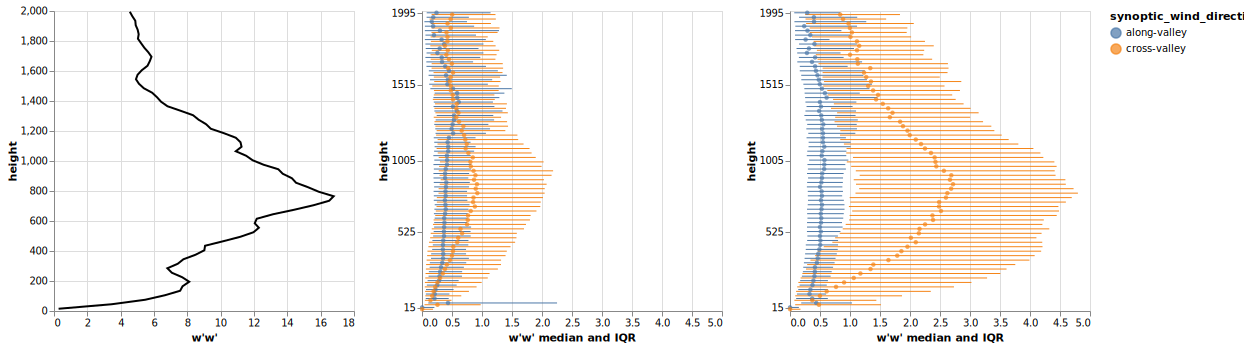

In [63]:
df_wstats_with_synoptic_conditions_this_plot = df_wstats_with_synoptic_conditions
# df_wstats_with_synoptic_conditions_this_plot = df_wstats_with_synoptic_conditions[df_wstats_with_synoptic_conditions.time.isin(tgrad_unstable_times)]

df_wvariance_stats = pd.concat([
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.25).rename('w_variance_lqr'),
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].quantile(0.75).rename('w_variance_uqr'),
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_variance'].median().rename('w_variance_median'),
], axis=1).reset_index()

plot_wvariance_iqr_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_slowwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_iqr_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_variance_lqr:Q'),
        alt.X2('w_variance_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_fastwinds = alt.Chart(df_wvariance_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_variance_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_variance_profile)
    | 
    (
        (plot_wvariance_iqr_slowwinds + plot_wvariance_median_slowwinds) 
        | 
        (plot_wvariance_iqr_fastwinds + plot_wvariance_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

## Skewness

#### Median plot for April 18

In [64]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
src = src[src.snr > 0.008]

In [65]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_2000_2100_median_skewness_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'").scale(domain=[-1, 1], clamp=True),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_2000_2100_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 2000': '20230418 2059'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_skewness):Q").title("w'w'"),
    alt.Y('height:Q'),
    order='height:Q'
)

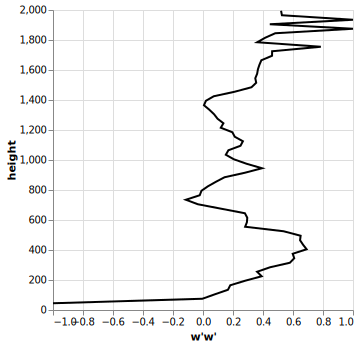

In [66]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
apr18_1400_1500_median_skewness_profile_smooth = alt.Chart(
    src[src.snr > 0.008].loc['20230418 1400': '20230418 1500'].reset_index()
).mark_line(color='black', strokeDash=[2,2]).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'").scale(domain=[-1, 1], clamp=True),
    alt.Y('height:Q').axis(None),
    order='height:Q'
)
apr18_1400_1500_median_skewness_profile = alt.Chart(
    src[src.snr > 0.008].loc['20230418 1400': '20230418 1500'].reset_index()
).mark_line(color='black').transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(w_skewness):Q").title("w'w'").scale(domain=[-1,1], clamp=True),
    alt.Y('height:Q'),
    order='height:Q'
)
apr18_1400_1500_median_skewness_profile

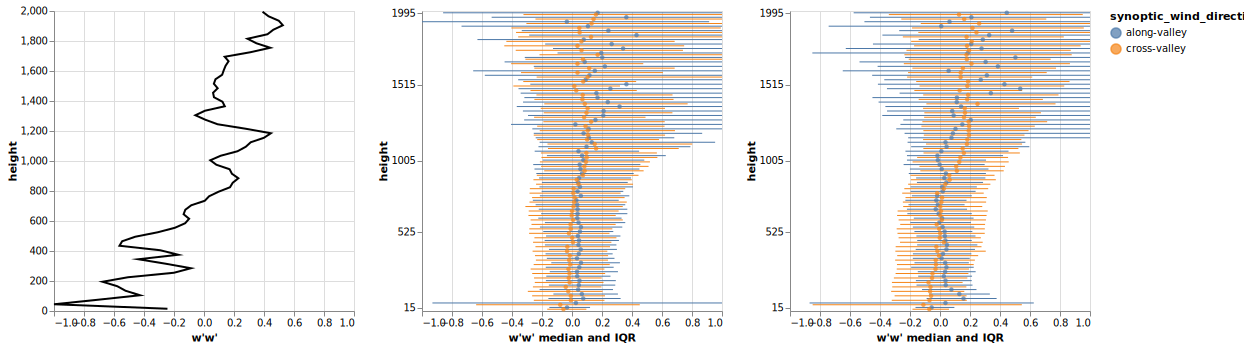

In [67]:
df_wstats_with_synoptic_conditions_this_plot = df_wstats_with_synoptic_conditions
# df_wstats_with_synoptic_conditions_this_plot = df_wstats_with_synoptic_conditions[df_wstats_with_synoptic_conditions.time.isin(tgrad_unstable_times)]

df_wskewness_stats = pd.concat([
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.25).rename('w_skewness_lqr'),
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].quantile(0.75).rename('w_skewness_uqr'),
    df_wstats_with_synoptic_conditions_this_plot.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['w_skewness'].median().rename('w_skewness_median'),
], axis=1).reset_index()

plot_wskewness_iqr_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_slowwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_iqr_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('w_skewness_lqr:Q').scale(domain=[-1, 1], clamp=True),
        alt.X2('w_skewness_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wskewness_median_fastwinds = alt.Chart(df_wskewness_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('w_skewness_median:Q').title("w'w' median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[15,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

(
    (apr18_2000_2100_median_skewness_profile)
    | 
    (
        (plot_wskewness_iqr_slowwinds + plot_wskewness_median_slowwinds) 
        | 
        (plot_wskewness_iqr_fastwinds + plot_wskewness_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='shared')

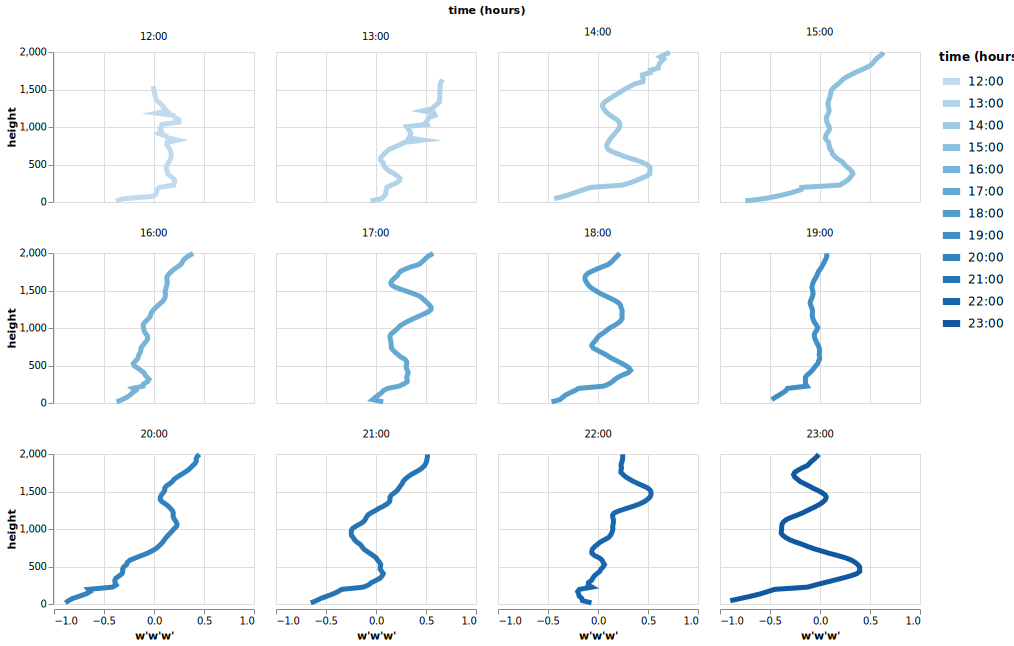

In [68]:
src = dl_wstats.sel(
    time = slice('20230418 0000', '20230419 0000')
).resample(
    time='30min'
).mean().sel(height = slice(0,2000)).to_dataframe().reset_index().set_index('time')
alt.Chart(
    src[src.snr > 0.008].loc['20230418 1200': '20230418 2359'].reset_index()
).mark_line(strokeWidth=5).transform_window(
    rolling_avg = 'mean(w_skewness)',
    frame=[-5,5],
    groupby=['time']
).encode(
    alt.X("mean(rolling_avg):Q").title("w'w'w'").scale(domain=[-1,1]),
    alt.Y('height:Q'),
    alt.Color('hours(time):O'),
    alt.Facet('hours(time):O', columns=4),
    order='height:Q'
).configure_legend(
    titleFontSize=12,  # Adjust title font size
    labelFontSize=12,  # Adjust label font size
    symbolSize=300,
    symbolStrokeWidth=7   # Adjust symbol size
).properties(width=200, height=150).display(renderer='svg')

# Normalize heights by PBL height?

## CBL heights from Bianca/Tropoe

In [ ]:
ds = xr.open_dataset("~/Downloads/guctropoeM1.c1.10min.2023.wholeperiod.cdf", chunks='auto')
ds = utils.modify_xarray_timezone(ds, 'UTC', 'US/Mountain')

First let's examine CBL heights on days of interest

In [ ]:
src_tropoe = ds['theta'].sel(time=slice('20230305', '20230305')).to_dataframe().query("height <= 2.5")
src_tropoe = src_tropoe.reset_index().dropna()
src_tropoe['theta'] = src_tropoe['theta'] - 273.15
src_tropoe['height'] = src_tropoe['height']*1000
src_tropoe = src_tropoe[src_tropoe.time.dt.hour % 3 == 0].query("height > 0")
src_tropoe = src_tropoe.assign(instrument = 'tropoe')

src_tower = pd.concat([
    sos_df_localtime.query("measurement == 'potential temperature'"),
    # sos_df_localtime.query("variable == 'Tsurf_c'")
])
src_tower = src_tower.set_index('time').sort_index().loc['20230305':'20230305'].reset_index()
src_tower['theta'] = src_tower['value']
src_tower = src_tower.assign(instrument = 'SOS thermometers')

src_cbl_height = ds['cbl'].sel(time=slice('20230305', '20230305')).to_dataframe().reset_index()    

src_combo = pd.concat([src_tower[['time', 'height', 'theta', 'instrument']].dropna(), src_tropoe.dropna()])
src_combo = src_combo[src_combo.time.dt.hour % 3 == 0]

src_combo = pd.concat([
    src_combo,
    src_cbl_height[src_cbl_height.time.dt.hour % 3 == 0].assign(instrument='tropoe CBL height')
])

In [ ]:
(alt.Chart().mark_line(point={'size': 20}).encode(
    alt.X('mean(theta):Q').title('Potential Temperature (˚C)'),
    alt.Y('height:Q').scale(type='log').title('Height (m)'),
    alt.Color('instrument:N'),
    order='height:Q',
).properties(width=100, height=200) + alt.Chart(
    
).mark_rule(strokeWidth=2).encode(
    alt.Y('mean(cbl):Q'),
    alt.Color('instrument:N').scale(range=['#1f77b4', '#ff7f0e', 'black']),
)).facet(
    column = alt.Column('hours(time):O'),
    row = alt.Row('date(time):O'),
    data = src_combo

).resolve_scale(x='independent')

In [ ]:
def w_var_chart(src, y_var):
    return (alt.Chart().mark_rule(opacity=0.5).encode(
        alt.X('q1(w_variance):Q', title="'w'w' median and IQR"),
        alt.X2('q3(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=100, height=200) + alt.Chart().mark_circle().encode(
        alt.X('median(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=100,height=200)).facet(
        column = alt.Column('hours(time):O'),
        row = alt.Row('date(time):O'),
        data=src,
        columns=3
    )
def w_skew_chart(src, y_var):
    return (alt.Chart().mark_rule(opacity=0.5).encode(
        alt.X('q1(w_skewness):Q', title="w'w'w' median and IQR").scale(domain=[-1,1], clamp=True),
        alt.X2('q3(w_skewness):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=100, height=200) + alt.Chart().mark_circle().encode(
        alt.X('median(w_skewness):Q').scale(domain=[-1,1], clamp=True),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=100,height=200)).facet(
        column = alt.Column('hours(time):O'),
        row = alt.Row('date(time):O'),
        data=src,
        columns=3
    )
src = df_wstats_with_synoptic_conditions[[
        'time', 'height', 'w_variance', 'w_skewness',
        'synoptic_wind_direction','synoptic_wind_speed',
    ]].set_index('time').loc['20230405'].reset_index()
src = src[src.time.dt.hour % 3 == 0]
w_var_chart(src, 'height') &\
w_skew_chart(src, 'height')

In [ ]:
df_wstats_w_pblht = ds['cbl'].to_dataframe().groupby(pd.Grouper(freq='30min')).mean().join(
    df_wstats_with_synoptic_conditions[[
        'time', 'height', 'w_variance', 'w_skewness',
        'synoptic_wind_direction','synoptic_wind_speed',
    ]].set_index('time')
)

In [ ]:
df_wstats_w_pblht['height_norm'] = df_wstats_w_pblht['height'] / (df_wstats_w_pblht['cbl'])

Create datasets of w statistics during rawinsonde release. Create one normalized df and one non-normalized.

In [ ]:
src = df_wstats_w_pblht
src = src.assign(
    height_binned = pd.cut(
        src['height'], 
        np.linspace(0,4000,21)
    ).apply(lambda interval: 0.5*(interval.left + interval.right)).astype('float')
)

src_normed = df_wstats_w_pblht.query("height_norm <= 2")
src_normed = src_normed.assign(
    height_norm_binned = pd.cut(
        src_normed['height_norm'], 
        np.linspace(0,2,21)
    ).apply(lambda interval: 0.5*(interval.left + interval.right)).astype('float')
)

In [ ]:
def w_var_chart(src, y_var):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=4, opacity=0.5).encode(
        alt.X('q1(w_variance):Q', title="'w'w' median and IQR"),
        alt.X2('q3(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=200, height=200)).facet(
        'synoptic_wind_speed:O', 
        data=src,
        columns=3
    )
def w_skew_chart(src, y_var):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_skewness):Q').scale(domain=[-1,1], clamp=True),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=4, opacity=0.5).encode(
        alt.X('q1(w_skewness):Q', title="w'w'w' median and IQR").scale(domain=[-1,1], clamp=True),
        alt.X2('q3(w_skewness):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=200, height=200)).facet(
        'synoptic_wind_speed:O', 
        data=src,
        columns=3
    )

In [ ]:
(w_var_chart(src.reset_index().dropna(), 'height_binned') |\
w_skew_chart(src.reset_index().dropna(), 'height_binned')).properties(title='Non-normalized, only including data when TROPOE created a CBL estimate')

In [ ]:
(w_var_chart(src_normed.reset_index().dropna(), 'height_norm_binned') |\
w_skew_chart(src_normed.reset_index().dropna(), 'height_norm_binned')).properties(title='Normalized, only including data when TROPOE created a CBL estimate')

## CBL heights from radiosondes

In [ ]:
# Inputs
DATE_FORMAT_STR = '%Y-%m-%d'
# PBLHT_DATA_STREAM = 'gucceilpblhtM1'      # from ceilometer
# PBLHT_DATA_STREAM = 'gucpblhtthermoM1'    # from tropoe and raman lidar
PBLHT_DATA_STREAM = 'gucpblhtsonde1mcfarlM1'   # from rawinsonde
# PBLHT_DATA_STREAM_FILEEXT = '.cdf'
PBLHT_OUTPUT_DIR = os.path.join(data_dir, PBLHT_DATA_STREAM)

In [ ]:
# # Download between start and end date
# file_list = act.discovery.download_arm_data(
#     username, token, PBLHT_DATA_STREAM, startdate, enddate, output = PBLHT_OUTPUT_DIR
# )

In [ ]:
files = sorted(glob.glob(os.path.join(PBLHT_OUTPUT_DIR, "*.cdf")))

In [ ]:
import tqdm

pbl_height_df = pd.DataFrame()
for file in tqdm.tqdm(files):
    vars = [ 'pbl_height_heffter', 'pbl_height_liu_liang', 'pbl_regime_type_liu_liang',]
    ds = xr.open_dataset(file)
    values = [ds[vars[0]].item(), ds[vars[1]].item(), ds[vars[2]].item()]
    date_str = ' '.join(
        file.split('/')[-1].split('.')[2:-1]
    )
    pbl_height_df = pd.concat([
        pd.DataFrame(list(zip(vars, values))).set_index(0).T.assign(time = date_str),
        pbl_height_df
    ])
pbl_height_df['time'] = pd.to_datetime(pbl_height_df['time'])
pbl_height_df = pbl_height_df.set_index('time').sort_index()
pbl_height_df.index = pbl_height_df.index.round('30min')
pbl_height_df = utils.modify_df_timezone(pbl_height_df.reset_index('time'), 'UTC', 'US/Mountain').set_index('time')
pbl_height_df[['pbl_height_heffter',	'pbl_height_liu_liang',]] = (
    pbl_height_df[['pbl_height_heffter',	'pbl_height_liu_liang',]] 
    - 
    2891
)
pbl_height_df.columns.name = 'algorithm'
pbl_height_df = pbl_height_df.dropna().drop_duplicates()

In [ ]:
pbl_height_df[pbl_height_df.index.hour > 12][['pbl_height_heffter',	'pbl_height_liu_liang']].plot(figsize=(20,4))

In [ ]:
pbl_height_df[pbl_height_df.index.hour > 12][['pbl_regime_type_liu_liang']].reset_index().plot.scatter(x='time', y='pbl_regime_type_liu_liang', figsize=(20,2))
plt.yticks([0, 1, 2])
plt.xticks([])
plt.xlabel('')
plt.show()

Plot radiosonde profiles and PBL heights together

In [ ]:
sondes_march = sondes_df_fulldataset[sondes_df_fulldataset.time > '20230315'][sondes_df_fulldataset.time < '20230401']
sondes_march['tpot'] = metpy.calc.potential_temperature(
    sondes_march['pres'].values * units('millibars'),
    sondes_march['tdry'].values * units('degC'),
).magnitude

sondes_march['tpot_virtual'] = metpy.calc.virtual_potential_temperature(
    sondes_march['pres'].values * units('millibars'),
    sondes_march['tdry'].values * units('degC'),
    metpy.calc.mixing_ratio_from_relative_humidity(
        sondes_march['pres'].values * units('millibars'),
        sondes_march['tdry'].values * units('degC'),
        sondes_march['rh'].values * units("percent"),
        phase = 'solid'
    )
).magnitude

In [ ]:
pbl_height_src = pbl_height_df[['pbl_height_heffter',	'pbl_height_liu_liang']].reset_index()
pbl_height_src = pbl_height_src[pbl_height_src.time >= sondes_march.time.min()]
pbl_height_src = pbl_height_src[pbl_height_src.time <= sondes_march.time.max()]
pbl_height_src['timeofday'] = pbl_height_src.time.dt.hour.apply(lambda h: h < 12).apply({False: 'Afternoon', True: 'Morning'}.get)

In [ ]:
(
    alt.Chart().mark_rule(size=2).encode(
        alt.Y('pbl_height_liu_liang').scale(domain=[0,4000]),
        alt.Color('timeofday:N'),
    ).properties(width=150, height=150)
    +
    alt.Chart().mark_circle(size=2).encode(
        alt.X('tpot_virtual:Q').scale(zero=False),
        alt.Y('height'),
        alt.Color('timeofday:N'),
    ).properties(width=150, height=150)
).facet(
    'date(time):O', columns=5,
    data = pd.concat([
        pbl_height_src,
        sondes_march[['tpot_virtual','height','time','timeofday',]]
    ])
)

Combine PBL height data with the w_stats timeseries.

In [ ]:
df_wstats_w_pblht = pbl_height_df[['pbl_height_liu_liang', 'pbl_regime_type_liu_liang']].join(
    df_wstats_with_synoptic_conditions[[
        'time', 'height', 'w_variance', 'w_skewness',
        'synoptic_wind_direction','synoptic_wind_speed',
    ]].set_index('time')
)

In [ ]:
df_wstats_w_pblht['height_norm'] = df_wstats_w_pblht['height'] / (df_wstats_w_pblht['pbl_height_liu_liang'])

Create datasets of w statistics during rawinsonde release. Create one normalized df and one non-normalized.

In [ ]:
src = df_wstats_w_pblht
src = src.assign(
    height_binned = pd.cut(
        src['height'], 
        np.linspace(0,4000,21)
    ).apply(lambda interval: 0.5*(interval.left + interval.right)).astype('float')
)

src_normed = df_wstats_w_pblht.query("height_norm <= 2")
src_normed = src_normed.assign(
    height_norm_binned = pd.cut(
        src_normed['height_norm'], 
        np.linspace(0,2,21)
    ).apply(lambda interval: 0.5*(interval.left + interval.right)).astype('float')
)

In [ ]:
def w_var_chart(src, y_var):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=4, opacity=0.5).encode(
        alt.X('q1(w_variance):Q', title="'w'w' median and IQR"),
        alt.X2('q3(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=200, height=200)).facet(
        'synoptic_wind_speed:O', 
        data=src,
        columns=3
    )
def w_skew_chart(src, y_var):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_skewness):Q').scale(domain=[-1,1], clamp=True),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=4, opacity=0.5).encode(
        alt.X('q1(w_skewness):Q', title="w'w'w' median and IQR").scale(domain=[-1,1], clamp=True),
        alt.X2('q3(w_skewness):Q'),
        alt.Y(f'{y_var}:Q'),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=200, height=200)).facet(
        'synoptic_wind_speed:O', 
        data=src,
        columns=3
    )

In [ ]:
(w_var_chart(src.reset_index().dropna(), 'height_binned') |\
w_skew_chart(src.reset_index().dropna(), 'height_binned'))

In [ ]:
(w_var_chart(src_normed.reset_index().dropna(), 'height_norm_binned') |\
w_skew_chart(src_normed.reset_index().dropna(), 'height_norm_binned'))

Splitting by rawinsonde-identified stability class

In [ ]:
def w_var_chart(src, y_var):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=2, opacity=0.5).encode(
        alt.X('q1(w_variance):Q', title="'w'w' median and IQR"),
        alt.X2('q3(w_variance):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=200, height=200)).facet(
        'pbl_regime_type_liu_liang',
        data=src,
        columns=3
    )
def w_skew_chart(src, y_var):
    return(alt.Chart().mark_circle().encode(
        alt.X('median(w_skewness):Q').scale(domain=[-1,1], clamp=True),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=200,height=200) + alt.Chart().mark_rule(size=2, opacity=0.5).encode(
        alt.X('q1(w_skewness):Q', title="w'w'w' median and IQR").scale(domain=[-1,1], clamp=True),
        alt.X2('q3(w_skewness):Q'),
        alt.Y(f'{y_var}:Q'),
    ).properties(width=200, height=200)).facet(
        'pbl_regime_type_liu_liang',
        data=src,
        columns=3
    )

In [ ]:
(
    w_var_chart(src[src.index.hour < 12].reset_index(), 'height_binned') |\
    w_skew_chart(src[src.index.hour < 12].reset_index(), 'height_binned')
).properties(title='04:30 data, split by ABL regime')

In [ ]:
(
    w_var_chart(src_normed[src_normed.index.hour < 12].reset_index(), 'height_norm_binned') |\
    w_skew_chart(src_normed[src_normed.index.hour < 12].reset_index(), 'height_norm_binned')
).properties(title='04:30 data, split by ABL regime, normalized by PBL')

In [ ]:
(
    w_var_chart(src[src.index.hour > 12].reset_index().query("pbl_regime_type_liu_liang != 2"), 'height_binned') |\
    w_skew_chart(src[src.index.hour > 12].reset_index().query("pbl_regime_type_liu_liang != 2"), 'height_binned')
).properties(title='16:30 data, split by ABL regime')

In [ ]:
(
    w_var_chart(src_normed[src_normed.index.hour > 12].reset_index(), 'height_norm_binned') |\
    w_skew_chart(src_normed[src_normed.index.hour > 12].reset_index(), 'height_norm_binned')
).properties(title='16:30 data, split by ABL regime, normalized by PBL')

Splitting by near-surface stability

In [ ]:
alt.Chart(
    pd.concat([
        pd.DataFrame(tgrad_unstable_times_3to20).assign(stability = 'unstable'),
        pd.DataFrame(tgrad_stable_times_3to20).assign(stability = 'stable'),
        pd.DataFrame(tgrad_neutral_times_3to20).assign(stability = 'neutral'),
    ]).rename(columns = {0:'time'})
).mark_rule().encode(
    alt.X('time:T'),
    alt.Row('stability:N'),
    alt.Color('stability:N')
).properties(width=1200)

In [ ]:
alt.Chart(
    pd.concat([
        pd.DataFrame(tgrad_unstable_times).assign(stability = 'unstable'),
        pd.DataFrame(tgrad_stable_times).assign(stability = 'stable'),
        pd.DataFrame(tgrad_neutral_times).assign(stability = 'neutral'),
    ]).rename(columns = {0:'time'})
).mark_rule().encode(
    alt.X('time:T'),
    alt.Row('stability:N'),
    alt.Color('stability:N')
).properties(width=1200)

In [ ]:
src_normed_w_static_stability = pd.concat([
    src_normed[src_normed.index.isin(tgrad_unstable_times_3to20)].assign(near_surface_static_stability='unstable'),
    src_normed[src_normed.index.isin(tgrad_stable_times_3to20)].assign(near_surface_static_stability='stable'),
    src_normed[src_normed.index.isin(tgrad_neutral_times_3to20)].assign(near_surface_static_stability='neutral'),
])
src_w_static_stability = pd.concat([
    src[src.index.isin(tgrad_unstable_times_3to20)].assign(near_surface_static_stability='unstable'),
    src[src.index.isin(tgrad_stable_times_3to20)].assign(near_surface_static_stability='stable'),
    src[src.index.isin(tgrad_neutral_times_3to20)].assign(near_surface_static_stability='neutral'),
])

In [ ]:
w_var_chart(src_w_static_stability[src_w_static_stability.index.hour < 12].reset_index(), 'height_binned') | w_skew_chart(src_w_static_stability[src_w_static_stability.index.hour < 12].reset_index(), 'height_binned')


In [ ]:
w_var_chart(src_w_static_stability[src_w_static_stability.index.hour > 12].reset_index(), 'height_binned') | w_skew_chart(src_w_static_stability[src_w_static_stability.index.hour > 12].reset_index(), 'height_binned')


In [ ]:
w_var_chart(src_normed_w_static_stability[src_normed_w_static_stability.index.hour < 12].reset_index(), 'height_norm_binned') | w_skew_chart(src_normed_w_static_stability[src_normed_w_static_stability.index.hour < 12].reset_index(), 'height_norm_binned')


In [ ]:
w_var_chart(src_normed_w_static_stability[src_normed_w_static_stability.index.hour > 12].reset_index(), 'height_norm_binned') | w_skew_chart(src_normed_w_static_stability[src_normed_w_static_stability.index.hour > 12].reset_index(), 'height_norm_binned')


# Look at wstats for different types of day

In [ ]:
wstats_df_allsnow = df_wstats_with_synoptic_conditions[[
        'time', 'height', 'w_variance', 'w_skewness',
        'synoptic_wind_direction','synoptic_wind_speed',
    ]].set_index('time')
wstats_df_nosnow = wstats_df_allsnow[wstats_df_allsnow.index > '20230528']
wstats_df_allsnow = wstats_df_allsnow[wstats_df_allsnow.index < '20230510']

In [ ]:
def w_var_chart(src):
    return (alt.Chart().mark_circle().encode(
        alt.X('median(w_variance):Q'),
        alt.Y('height:Q').bin(step=60),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=160,height=160) + alt.Chart().mark_rule(size=2, opacity=0.5).encode(
        alt.X('q1(w_variance):Q', title="'w'w' median and IQR").scale(domain=[0,4], clamp=True),
        alt.X2('q3(w_variance):Q'),
        alt.Y('height:Q').bin(step=60),
        alt.Color('synoptic_wind_direction:N')
    ).properties(width=160, height=160)).facet(
        column = 'hours(time)',
        data = src
    )

In [ ]:
w_var_chart(
    wstats_df_allsnow[
        (wstats_df_allsnow.index.hour % 3 == 0)
    ].reset_index()
).properties(
    title = f'All dates during complete snow cover (30 Nov 2022 - 10 May 2023) (N = {len(wstats_df_allsnow.index.unique())} 30 min periods)'
)

In [ ]:
w_var_chart(wstats_df_nosnow[wstats_df_nosnow.index.hour%3==0].reset_index()).properties(
    title = f'All dates during near zeri snow cover (28 May 2023 - 15 June 2023) (N = {len(wstats_df_nosnow.index.unique())} 30 min periods)'
)

In [ ]:
w_stats_night_and_day = wstats_df_allsnow[
        wstats_df_allsnow.index.hour.isin([4,16])
    ].reset_index()

(alt.Chart().mark_circle().encode(
    alt.X('median(w_variance):Q'),
    alt.Y('height:Q').bin(step=60),
    alt.Color('synoptic_wind_direction:N')
).properties(width=160,height=160) + alt.Chart().mark_rule(size=2, opacity=0.5).encode(
    alt.X('q1(w_variance):Q', title="'w'w' median and IQR").scale(domain=[0,4], clamp=True),
    alt.X2('q3(w_variance):Q'),
    alt.Y('height:Q').bin(step=60),
    alt.Color('synoptic_wind_direction:N')
).properties(width=160, height=160)).facet(
    column = 'hours(time)',
    # row = 'synoptic_wind_speed',
    data = w_stats_night_and_day
).properties(
    title = f'All dates during complete snow cover (30 Nov 2022 - 10 May 2023) (N = {len(wstats_df_allsnow.index.unique())} 30 min periods)'
)

In [ ]:
sondetpot_night_and_day = sondes_ds.sel(
    time = slice(
        w_stats_night_and_day.time.min(),
        w_stats_night_and_day.time.max()
    )
)[['pres','tdry', 'alt']]
sondetpot_night_and_day = sondetpot_night_and_day.to_dataframe().reset_index()
sondetpot_night_and_day = utils.modify_df_timezone(sondetpot_night_and_day, 'UTC', 'US/Mountain')
sondetpot_night_and_day = sondetpot_night_and_day.assign(
    tpot = metpy.calc.potential_temperature(
        sondetpot_night_and_day['pres'].values * units('millibars'),
        sondetpot_night_and_day['tdry'].values * units('degC'),
    ).magnitude
)
sondetpot_night_and_day['height'] = sondetpot_night_and_day['alt'] - 2891
sondetpot_night_and_day = sondetpot_night_and_day.query("height <= 2000")
sondetpot_night_and_day['hour'] = sondetpot_night_and_day['time'].dt.hour.apply(
    lambda h: 4 if h < 12 else 16
)
sondetpot_night_and_day['time'] = sondetpot_night_and_day['time'].dt.round('30min')

sondetpot_night_and_day = sondetpot_night_and_day.set_index('time').join(
    df_wstats_with_synoptic_conditions[[
        'time',
        'synoptic_wind_direction','synoptic_wind_speed',
    ]].drop_duplicates().set_index('time')
)

sondetpot_night_and_day = sondetpot_night_and_day.dropna()

sondetpot_night_and_day = sondetpot_night_and_day[sondetpot_night_and_day.index.hour.isin([4,16])]

In [ ]:
(alt.Chart().mark_circle().encode(
    alt.X('median(tpot):Q').scale(zero=False),
    alt.Y('height:Q').bin(step=60),
    alt.Color('synoptic_wind_direction:N')
).properties(width=160,height=160) + alt.Chart().mark_rule(size=2, opacity=0.5).encode(
    alt.X('q1(tpot):Q', title="Tpot median and IQR"),
    alt.X2('q3(tpot):Q'),
    alt.Y('height:Q').bin(step=60),
    alt.Color('synoptic_wind_direction:N')
).properties(width=160, height=160)).facet(
    column = 'hours(time)',
    # row = 'synoptic_wind_speed',
    data = sondetpot_night_and_day.reset_index()
)

# Compare wind direction shear and mixing intensity

In [ ]:
wprof_resampled_ds = prof_df_localtime.groupby([pd.Grouper(freq='30min'), 'height'])[['wind_speed', 'wind_direction']].mean().to_xarray()
wprof_resampled_df = wprof_resampled_ds.to_dataframe()
wprof_resampled_df_smooth = pd.DataFrame(
    wprof_resampled_df.groupby(level=0).wind_direction.apply(lambda x: x.rolling(window=3, min_periods=1).mean())
).droplevel(0).query("height < 2000")

In [ ]:
alt.Chart(wprof_resampled_df_smooth.loc['20230418 1500':'20230418 1800'].reset_index()).mark_line().encode(
    alt.X('wind_direction:Q'),
    alt.Y('height:Q'),
    alt.Facet('hoursminutes(time):O'),
    order='height'
).properties(width=100, height=200)

# Analyze bulk shear 

Gather doppler lidar profiles and calculate shear terms

In [ ]:
prof_data_binned_ds = utils.modify_xarray_timezone(prof_ds[[
    'wind_speed', 'wind_direction', 'u', 'v'
]], 'UTC', 'US/Mountain')
# prof_data_binned_ds = prof_data_binned_ds.rolling(height=2).mean()
prof_data_binned_ds['U'] = np.sqrt(prof_data_binned_ds['u']**2 + prof_data_binned_ds['v']**2)
prof_data_binned_ds['dU/dz'] = prof_data_binned_ds['U'].differentiate('height')
prof_data_binned_ds['dDir/dz'] = prof_data_binned_ds['wind_direction'].differentiate('height')

prof_data_binned_ds['du/dz'] = prof_data_binned_ds['u'].differentiate('height')
prof_data_binned_ds['dv/dz'] = prof_data_binned_ds['v'].differentiate('height')
prof_data_binned_ds['dU/dz_rot'] =  np.sqrt(prof_data_binned_ds['du/dz']**2 + prof_data_binned_ds['dv/dz']**2)

Look at case studies

In [ ]:
abs(prof_data_binned_ds.sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
)['dU/dz']).T.plot.contourf(figsize=(10,3), vmax=.1, levels=20)
plt.show()

In [ ]:
abs(prof_data_binned_ds.sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
)['dDir/dz']).T.plot.contourf(figsize=(10,3), vmax=2, levels=20)
plt.show()

Gather the 20230418 w'w' stats so we can plot those adjascent

In [ ]:
# Inputs
start_date = "20230418"
end_date = "20230419"
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join(data_dir, DLW_DATA_STREAM)
# file_list = act.discovery.download_arm_data(
#             username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)
file_list = [f for f in glob.glob(os.path.join(data_dir, DLW_DATA_STREAM, '*.nc')) if start_date in f or end_date in f]
dl_wstats = xr.open_mfdataset(file_list)
dl_wstats = utils.modify_xarray_timezone(
    dl_wstats,
    'UTC',
    'US/Mountain'
)

In [ ]:
abs(prof_data_binned_ds.sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
)['dU/dz']).T.plot.contourf(figsize=(10,3), vmax=.2, levels=20, cmap='Reds')
dl_wstats['w_variance'].sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
).plot.contour(x = 'time', y='height', levels=1, colors='k')
plt.show()

In [ ]:
abs(prof_data_binned_ds.sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
)['dDir/dz']).T.plot.contourf(figsize=(10,3), vmax=3, levels=20, cmap='Reds')
dl_wstats['w_variance'].sel(
    time=slice('20230418', '20230418'),
    height=slice(0,2000)
).plot.contour(x = 'time', y='height', levels=1, colors='k')
plt.show()

Look at seasonal stats

In [ ]:
prof_data_binned = prof_data_binned_ds[[
    'U', 'du/dz', 'dv/dz', 'dU/dz', 'dU/dz_rot', 'dDir/dz'
]].to_dataframe().reset_index()

In [ ]:
prof_data_w_synoptic_winds = prof_data_binned.set_index('time').groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index().set_index('time').join(
    df_wstats_with_synoptic_conditions[['time', 'synoptic_wind_direction', 'synoptic_wind_speed']].drop_duplicates().set_index('time')
).dropna()

In [ ]:
prof_data_w_synoptic_winds[['du/dz', 'dv/dz', 'dU/dz', 'dU/dz_rot', 'dDir/dz']] = np.abs(
    prof_data_w_synoptic_winds[['du/dz', 'dv/dz', 'dU/dz', 'dU/dz_rot', 'dDir/dz']]
)

In [ ]:
shear_stats = pd.concat([
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dU/dz'].quantile(0.25).rename('dU/dz_lqr'),
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dU/dz'].quantile(0.75).rename('dU/dz_uqr'),
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dU/dz'].median().rename('dU/dz_median'),
], axis=1).reset_index()
shear_stats = shear_stats.query("height <= 2000")

In [ ]:
plot_wvariance_iqr_slowwinds = alt.Chart(shear_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('dU/dz_lqr:Q'),
        alt.X2('dU/dz_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_slowwinds = alt.Chart(shear_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('dU/dz_median:Q').title("dU/dz median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_iqr_fastwinds = alt.Chart(shear_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('dU/dz_lqr:Q'),
        alt.X2('dU/dz_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_fastwinds = alt.Chart(shear_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('dU/dz_median:Q').title("dU/dz median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

( 
    (
        (plot_wvariance_iqr_slowwinds + plot_wvariance_median_slowwinds) 
        | 
        (plot_wvariance_iqr_fastwinds + plot_wvariance_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

In [ ]:
rotshear_stats = pd.concat([
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dDir/dz'].quantile(0.25).rename('dDir/dz_lqr'),
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dDir/dz'].quantile(0.75).rename('dDir/dz_uqr'),
    prof_data_w_synoptic_winds.groupby(['height', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dDir/dz'].median().rename('dDir/dz_median'),
], axis=1).reset_index()
rotshear_stats = rotshear_stats.query("height <= 2000")

In [ ]:
plot_wvariance_iqr_slowwinds = alt.Chart(rotshear_stats.query("synoptic_wind_speed == '<= 10'")).mark_rule().encode(
        alt.X('dDir/dz_lqr:Q'),
        alt.X2('dDir/dz_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_slowwinds = alt.Chart(rotshear_stats.query("synoptic_wind_speed == '<= 10'")).mark_circle(size=20).encode(
        alt.X('dDir/dz_median:Q').title("dDir/dz median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_iqr_fastwinds = alt.Chart(rotshear_stats.query("synoptic_wind_speed == '> 10'")).mark_rule().encode(
        alt.X('dDir/dz_lqr:Q'),
        alt.X2('dDir/dz_uqr:Q'),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)
plot_wvariance_median_fastwinds = alt.Chart(rotshear_stats.query("synoptic_wind_speed == '> 10'")).mark_circle(size=20).encode(
        alt.X('dDir/dz_median:Q').title("dDir/dz median and IQR"),
        alt.Y('height:O').scale(reverse=True).axis(values=[0,525, 1005, 1515,1995]),
        alt.YOffset('synoptic_wind_direction:N'),
        alt.Color('synoptic_wind_direction'),
    ).properties(height=300)

( 
    (
        (plot_wvariance_iqr_slowwinds + plot_wvariance_median_slowwinds) 
        | 
        (plot_wvariance_iqr_fastwinds + plot_wvariance_median_fastwinds)
    ).resolve_scale(x='shared', y='shared', color='shared')
).resolve_scale(x='independent')

## Analyze correlation, w'w' vs shear

2. Shear analysis:
    1. Calculate mean du/dz, dv/dz, and dU/dz for bins of z, from doppler lidar vertical wind profiles
    2. Calculate mean w’w’ for the same bins of z, from doppler lidar vertical staring profiles
    3. Plot correlation between w’w’ and the 3 shear terms, separately for each height bin
    4. If there is correlation:
        1. Scale w’w’ profiles with the shear values
        2. Does this reduce scatter in a replicated figure 4B plot?


### bin wtats into 100m bins

In [ ]:
bin_edges = np.linspace(-50,4050,42)
bin_edges

In [ ]:
df_wstats_with_synoptic_conditions['height_bin'] = pd.cut(df_wstats_with_synoptic_conditions.height, bin_edges).apply(
    lambda interval: 0.5*(interval.left + interval.right)
).astype('float')
df_wstats_binned = df_wstats_with_synoptic_conditions.groupby([
    'time','height_bin','synoptic_wind_direction', 'synoptic_wind_speed'
])[['w_variance', 'w_skewness', 'snr']].mean()
df_wstats_binned = df_wstats_binned.reset_index().set_index(['time', 'height_bin'])
df_wstats_binned.head(3)

We use characterize shear using the following calculation, 

$$\sqrt{\frac{d u}{d z}^2 + \frac{d v}{d z}^2}$$

In [ ]:
prof_data_binned['height_bin'] = pd.cut(prof_data_binned.height, bin_edges).apply(
    lambda interval: 0.5*(interval.left + interval.right)
).astype('float')
prof_data_binned = prof_data_binned.set_index('time').groupby(
    [pd.Grouper(freq='30min'), 'height_bin']
)[['du/dz', 'dv/dz', 'dU/dz', 'dU/dz_rot', 'dDir/dz']].mean()
prof_data_binned.head(3)

In [ ]:
tke_budget_df = prof_data_binned.join(
    df_wstats_binned
).dropna().reset_index()
tke_budget_df.head()

In [ ]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

dir_gradient_stats = tke_budget_df.groupby(['height_bin', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dDir/dz'].agg([
    'median', 'mean',percentile(.75), percentile(.25)
])
dir_gradient_stats = np.abs(dir_gradient_stats).reset_index()
spd_gradient_stats = tke_budget_df.groupby(['height_bin', 'synoptic_wind_direction', 'synoptic_wind_speed'])['dU/dz'].agg([
    'median', 'mean',percentile(.75), percentile(.25)
])
spd_gradient_stats = np.abs(spd_gradient_stats).reset_index()
dir_gradient_stats.head()

In [ ]:
tke_budget_df.set_index(['time', 'height_bin']).loc[('20230418', 300)]['dU/dz'].plot()
tke_budget_df.set_index(['time', 'height_bin']).loc[('20230418', 900)]['dU/dz'].plot()
tke_budget_df.set_index(['time', 'height_bin']).loc[('20230418', 300)]['dDir/dz'].plot()
tke_budget_df.set_index(['time', 'height_bin']).loc[('20230418', 900)]['dDir/dz'].plot()

In [ ]:
def get_faceted_r2_chart():
    return (   
        alt.Chart().mark_circle(size=5).encode(
            alt.X('dU/dz_rot:Q'),
            alt.Y('w_variance:Q').title("w'w'"),
        ).properties(width=100, height=100)
    + 
        alt.Chart().mark_circle(size=5).encode(
            alt.X('dU/dz_rot:Q'),
            alt.Y('w_variance:Q'),
        ).properties(width=100, height=100).transform_regression(
            'dU/dz_rot', 'w_variance', method='linear', as_=['dU/dz_rot', 'w_variance_pred']
        ).mark_line(color='red').encode(
            alt.X('dU/dz_rot:Q'),
            alt.Y('w_variance_pred:Q')
        )
    +
        alt.Chart().transform_regression(
            'dU/dz_rot', 'w_variance', method='linear', params=True
        ).transform_calculate(
            r_squared='datum.rSquared'
        ).mark_text(align='left', baseline='top', dx=7, dy=-7).encode(
            text=alt.Text('r_squared:Q', format='.2f')
        )
    )

In [ ]:
get_faceted_r2_chart().facet(
    column = 'height_bin:O',
    data = tke_budget_df.set_index('time').loc['20230418']
).properties(title='18 April 2023')

In [ ]:
get_faceted_r2_chart().facet(
    column = 'height_bin:O',
    data = tke_budget_df.set_index('time').loc['20230409']
).properties(title='9 April 2023')

In [ ]:
get_faceted_r2_chart().facet(
    column = 'height_bin:O',
    data = tke_budget_df.set_index('time')
).properties(title='All data')

In [ ]:
get_faceted_r2_chart().facet(
    column = 'height_bin:O',
    data = tke_budget_df.set_index('time').query("synoptic_wind_direction == 'cross-valley'")
).properties(title='Cross-valley winds')

In [ ]:
get_faceted_r2_chart().facet(
    column = 'height_bin:O',
    data = tke_budget_df.set_index('time').query("synoptic_wind_direction == 'along-valley'")
).properties(title='Along-valley winds')

In [ ]:
alt.Chart(
    tke_budget_df
).mark_boxplot(size=5, outliers=False, opacity=0.5).encode(
    alt.X('w_variance:Q').title("w'w'"),
    alt.Y('height_bin:O').scale(reverse=True).title('height (m)'),
    alt.Color('synoptic_wind_direction:N'),
    alt.Facet('synoptic_wind_speed:N')
).properties(width=200, height=200)

In [ ]:
tke_budget_df = tke_budget_df.set_index('time').join(
    tke_budget_df.query("height_bin == 900").set_index('time')['dU/dz_rot'].rename('norm_value')
).reset_index()

In [ ]:
tke_budget_df['w_variance_normed'] = tke_budget_df['w_variance']**0.5 / tke_budget_df['norm_value']

In [ ]:
alt.Chart(
    tke_budget_df
).mark_boxplot(size=5, outliers=False, opacity=0.5).encode(
    alt.X('w_variance_normed:Q').title("w'w'"),
    alt.Y('height_bin:O').scale(reverse=True).title('height (m)'),
    alt.Color('synoptic_wind_direction:N'),
    alt.Facet('synoptic_wind_speed:N')
).properties(width=200, height=200)

1. Look at surface sensible heat fluxes at different heights on tower C, with the intent to demonstrate:
     1. Small surface heat fluxes on 3/5 and 4/5, the days we’ve been emailing about
     2. Near-surface sensible heat flux was small during all subsets of cases (slow and fast, along and across valley synoptic winds) and can thus not be the driving factor for turbulence and also not be the decisive factor for the difference between the subset of cases. 
         1. IE look at distribution of near surface heat fluxes during the different cases

In [ ]:
surface_heatflux_df = tke_budget_df.set_index('time').join(
    sos_df.query("variable == 'w_tc__3m_c'").set_index('time').value.rename('w_tc__3m_c')
).join(
    sos_df.query("variable == 'w_tc__10m_c'").set_index('time').value.rename('w_tc__10m_c')
).join(
    sos_df.query("variable == 'w_tc__20m_c'").set_index('time').value.rename('w_tc__20m_c')
)

In [ ]:
src = surface_heatflux_df.copy()[['w_tc__3m_c','w_tc__10m_c','w_tc__20m_c', 'synoptic_wind_speed', 'synoptic_wind_direction']].drop_duplicates()
src['w_tc__3m_c'] = w_tc_to_watts(src['w_tc__3m_c'].values)
src['w_tc__10m_c'] = w_tc_to_watts(src['w_tc__10m_c'].values)
src['w_tc__20m_c'] = w_tc_to_watts(src['w_tc__20m_c'].values)
alt.Chart(src).mark_boxplot(outliers=False).transform_fold([
    'w_tc__3m_c', 'w_tc__10m_c', 'w_tc__20m_c'
]).encode(
    alt.X('synoptic_wind_direction:N'),
    alt.XOffset('key:O').sort(['w_tc__3m_c', 'w_tc__10m_c', 'w_tc__20m_c']),
    alt.Color('key:N').sort(['w_tc__3m_c', 'w_tc__10m_c', 'w_tc__20m_c']),
    alt.Y('value:Q').title("w'T' (W/m^2)"),
    alt.Facet('synoptic_wind_speed:N')
).properties(width=150, height=300)

In [ ]:
surface_heatflux_df.loc['20230305']['w_tc__3m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230305']['w_tc__10m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230305']['w_tc__20m_c'].plot(figsize=(6,2))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.ylim(-0.15, 0.1)

In [ ]:
surface_heatflux_df.loc['20230405']['w_tc__3m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230405']['w_tc__10m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230405']['w_tc__20m_c'].plot(figsize=(6,2))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.ylim(-0.15, 0.1)

In [ ]:
surface_heatflux_df.loc['20230409']['w_tc__3m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230409']['w_tc__10m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230409']['w_tc__20m_c'].plot(figsize=(6,2))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.ylim(-0.15, 0.1)

In [ ]:
surface_heatflux_df.loc['20230418']['w_tc__3m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230418']['w_tc__10m_c'].plot(figsize=(6,2))
surface_heatflux_df.loc['20230418']['w_tc__20m_c'].plot(figsize=(6,2))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.ylim(-0.15, 0.1)

# Identify RHI scans during fast cross-valley winds, and plot them all

How many scans of this type exist??

For now, let's start with synoptic winds > 20 m/s

In [ ]:
# fastest_synoptic_wind_speeds = winds_ge10_times
fastest_synoptic_wind_speeds = synoptic_winds_30min [ synoptic_winds_30min.wind_speed > 18 ] 
fastest_synoptic_wind_speeds

In [ ]:
times_with_fast_cross_valley_winds = pd.DataFrame(pd.Series(list(
    set(fastest_synoptic_wind_speeds.index).intersection(pd.to_datetime(cross_valley_wind_times))
)).sort_values())
rhi_scan_file_names = pd.DataFrame(pd.Series(
    glob.glob("/Users/elischwat/Development/data/sublimationofsnow/gucdlrhiM1.b1/gucdlrhiM1.b1.*.cdf")
))

In [ ]:
import datetime as dt

In [ ]:
# add minutes so we the times overlap with the times of the scans
times_with_fast_cross_valley_winds[1] = times_with_fast_cross_valley_winds[0] + dt.timedelta(minutes=15)
times_with_fast_cross_valley_winds[2] = times_with_fast_cross_valley_winds[0] + dt.timedelta(minutes=18)
times_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.drop(columns=0)
times_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.melt()[['value']]

In [ ]:
rhi_scan_file_names[1] = rhi_scan_file_names[0].apply(lambda s : s.split('/gucdlrhiM1.b1.')[-1].split('.cdf')[0][:-2])

rhi_scan_file_names[2] = rhi_scan_file_names[1].apply(
    lambda s: dt.datetime(
        year = int(s[:4]),
        month = int(s[4:6]),
        day = int(s[6:8]),
        hour = int(s[9:11]),
        minute = int(s[11:13]),
    )
)

In [ ]:
scan_files_with_fast_cross_valley_winds = times_with_fast_cross_valley_winds.set_index('value').join(
    rhi_scan_file_names.set_index(2)
)[[0]].dropna()

In [ ]:
print(f"I have this many scans downloaded that are during fast, cross-valley winds: {len(scan_files_with_fast_cross_valley_winds)}")

Plot and save all scans

In [ ]:
output_dir = './rhi_scans_during_fast_crossvalley_winds/'

In [ ]:
profile_ds = xr.open_dataset('profile.nc')

In [ ]:
for f in sorted(
    scan_files_with_fast_cross_valley_winds[0].values
):
    try: 
        ds = xr.open_dataset(f)
        ds['x'] = ds['range']*np.cos(np.deg2rad(ds['elevation']))
        ds['z'] = ds['range']*np.sin(np.deg2rad(ds['elevation']))
        ds['x'] = - ds['x']
        ds['SNR'] = ds['intensity'] - 1
        ds = ds.where(ds['SNR'] > 0.008)
        ds = ds.sel(range=slice(0,3000))
        plt.subplots(figsize=(9.6, 4))
        plt.contourf(
            ds['x'].values.T, ds['z'].values.T,
            ds['radial_velocity'].values,
            cmap='gist_ncar',
            levels=50
        )
        plt.fill_between(
            profile_ds.data.to_dataframe().index,
            -20,
            profile_ds.data.to_dataframe().data,
            color='grey'
        )
        plt.xlim(-2250,500)
        plt.ylim(0,2000)
        plt.colorbar()
        plt.gca().set_aspect('equal')
        name = f.split('gucdlrhiM1.b1/gucdlrhiM1.b1.')[1][:-4]
        plt.title(name)
        plt.savefig(os.path.join(output_dir, name + '.png'))
        plt.close()
    except Exception as exc:
        print(f'Failed on {f}')